# 技術側の分析


<a id=top></a>


<a href="#data">データインポート</a>


---


<a id=init></a>

## **1. モジュールインポート・初期条件設定**


In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../../src")
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams["font.family"] = "Meiryo"
plt.rcParams["font.size"] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = "{:.3f}".format

In [2]:
import initial_condition
from process import weight
from visualize import rank as vr

In [3]:
global data_dir, ex_dir, output_dir
data_dir = "../../data/processed/internal/technology/"
ex_dir = "../../data/processed/external/schmoch/"
output_dir = "../../output/figures/"

In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
region_corporation = initial_condition.REGION_CORPORATION
applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT

color_list = initial_condition.COLOR_LIST

input_condition = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}'
fig_name_base = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}.png'


In [5]:
# 条件確認
input_condition

'app_nendo_all_p_3_right_person_name_fraction_schmoch35_fraction'

In [6]:
period_order_dict = {
    f"{period_start}-{period_start+year_range-1}": i
    for i, period_start in enumerate(range(year_start, year_end + 1, year_range))
}

period_order_dict[f"{year_start}-{year_end}"] = len(period_order_dict)
period_order_dict

{'1981-1990': 0, '1991-2000': 1, '2001-2010': 2, '1981-2010': 3}

<a href=#top>TOP に戻る</a>

---


<a id="data"></a>

## **2. データインポート**


In [7]:
df = pd.read_csv(
    f"{data_dir}{input_condition}.csv", sep=","
)

schmoch_df = pd.read_csv(
    f"{ex_dir}35.csv", encoding="utf-8", sep=",", usecols=["Field_number", "Field_en"]
).drop_duplicates()

# df = (
#     pd.merge(
#         df, schmoch_df, left_on=classification, right_on="Field_number", how="left"
#     )
#     .drop(columns=["Field_number", classification])

#     .rename(columns={"Field_en": classification})

# )
df = df.sort_values(
    f"{ar}_{year_style}_period", key=lambda col: col.map(period_order_dict)
)

df

,app_nendo_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
0,1981-1990,53258.648,917,306,-1.355,5.843,305.468,6.282,314.287,6.432,...,326.122,6.566,326.738,6.572,327.096,6.576,327.303,6.578,327.423,"Electrical machinery, apparatus, energy"
104,1981-1990,28650.059,530,192,-0.306,6.562,319.331,6.499,332.466,6.512,...,327.821,6.574,327.646,6.578,327.586,6.579,327.570,6.580,327.570,"Engines, pumps, turbines"
120,1981-1990,17410.100,842,402,-0.225,6.067,354.885,6.356,339.935,6.476,...,327.949,6.575,327.711,6.578,327.620,6.580,327.589,6.580,327.580,Mechanical elements
64,1981-1990,26017.383,567,259,1.463,7.622,337.248,6.938,335.698,6.754,...,328.749,6.597,328.288,6.590,328.006,6.587,327.836,6.584,327.734,"Macromolecular chemistry, polymers"
28,1981-1990,32872.667,483,150,-1.343,6.620,279.337,6.488,306.082,6.501,...,325.735,6.568,326.561,6.573,327.015,6.577,327.267,6.579,327.407,Semiconductors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,1981-2010,6928.900,609,372,1.081,8.470,377.606,7.832,370.508,7.566,...,360.704,7.335,360.126,7.327,359.790,7.323,359.598,7.321,359.487,Analysis of biological materials
37,1981-2010,157480.168,1626,481,-0.564,7.570,362.748,7.345,353.077,7.298,...,358.410,7.314,358.813,7.316,359.043,7.317,359.173,7.318,359.247,Measurement
113,1981-2010,97979.104,1508,504,0.871,7.030,399.405,7.262,375.652,7.316,...,360.623,7.323,360.054,7.322,359.739,7.321,359.564,7.320,359.466,Other special machines
101,1981-2010,91314.697,1439,417,0.262,6.441,385.282,7.045,369.937,7.207,...,359.830,7.314,359.592,7.317,359.472,7.318,359.411,7.319,359.379,Machine tools


In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import squarify

# sns.set_style("darkgrid")
# df_2col = df[df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}"][
#     [classification, "reg_num"]
# ].sort_values("reg_num", ascending=False)
# # df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/import squarify.csv")

# # df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
# # display(df_raw)
# # display(df_raw.groupby('class').size().reset_index(name='counts'))
# labels = df_2col.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1], 1)) + ")", axis=1)
# sizes = df_2col["reg_num"].values.tolist()
# colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]
# # colors = color_list
# # display(sizes)
# plt.figure(figsize=(40, 30), dpi=120)
# squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

# plt.title("Treemap of Vechile Class")
# plt.axis("off")
# plt.show()

In [9]:
# df_2col

In [10]:
# pg = sns.pairplot(
#     df[
#         [
#             f"{ar}_{year_style}_period",
#             classification,
#             "reg_num",
#             region_corporation,
#             "tci",
#             "ubiquity",
#         ]
#         + [f"ki_{i}" for i in range(2, 20 + 1, 2)]
#     ],

#     hue=f"{ar}_{year_style}_period",
#     palette="Blues",
# )
# pg

In [11]:
df[
    df[classification].isin(
        [
            "Analysis of biological materials",

            "Organic fine chemistry",

            "Biotechnology",

            "Pharmaceuticals",

            "Macromolecular chemistry, polymers",

            "Food chemistry",

            "Basic materials chemistry",

            "Materials, metallurgy",

            "Surface technology, coating",

            "Chemical engineering",

            "Other special machines",
        ]
    )
    & (df[f"{ar}_{year_style}_period"] == "1981-2010")
]

,app_nendo_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
81,1981-2010,70207.893,1282,490,0.717,7.680,392.986,7.454,373.169,7.381,...,360.361,7.325,359.906,7.322,359.657,7.321,359.518,7.320,359.441,"Surface technology, coating"
77,1981-2010,96984.937,1111,351,0.769,8.308,390.299,7.585,374.807,7.417,...,360.455,7.325,359.957,7.323,359.684,7.321,359.533,7.320,359.449,"Materials, metallurgy"
89,1981-2010,48801.458,1404,606,0.860,7.990,403.963,7.549,374.675,7.419,...,360.545,7.327,360.016,7.323,359.720,7.321,359.554,7.320,359.461,Chemical engineering
73,1981-2010,49795.784,1116,474,1.176,8.086,387.338,7.722,373.945,7.526,...,360.900,7.334,360.228,7.327,359.845,7.323,359.627,7.321,359.504,Basic materials chemistry
65,1981-2010,73747.874,857,302,1.306,8.272,383.865,7.742,375.707,7.537,...,361.092,7.336,360.336,7.328,359.906,7.324,359.662,7.322,359.523,"Macromolecular chemistry, polymers"
61,1981-2010,13832.883,443,295,1.641,8.451,369.128,8.035,372.912,7.693,...,361.425,7.344,360.546,7.332,360.033,7.326,359.737,7.323,359.567,Pharmaceuticals
57,1981-2010,18842.517,613,382,1.352,8.730,374.574,7.948,371.768,7.631,...,361.057,7.340,360.330,7.330,359.908,7.325,359.665,7.322,359.526,Biotechnology
53,1981-2010,49762.793,666,339,1.586,8.283,373.047,8.008,373.528,7.680,...,361.366,7.343,360.509,7.332,360.011,7.326,359.724,7.323,359.559,Organic fine chemistry
41,1981-2010,6928.900,609,372,1.081,8.470,377.606,7.832,370.508,7.566,...,360.704,7.335,360.126,7.327,359.790,7.323,359.598,7.321,359.487,Analysis of biological materials
113,1981-2010,97979.104,1508,504,0.871,7.030,399.405,7.262,375.652,7.316,...,360.623,7.323,360.054,7.322,359.739,7.321,359.564,7.320,359.466,Other special machines


1981-2010 -0.069


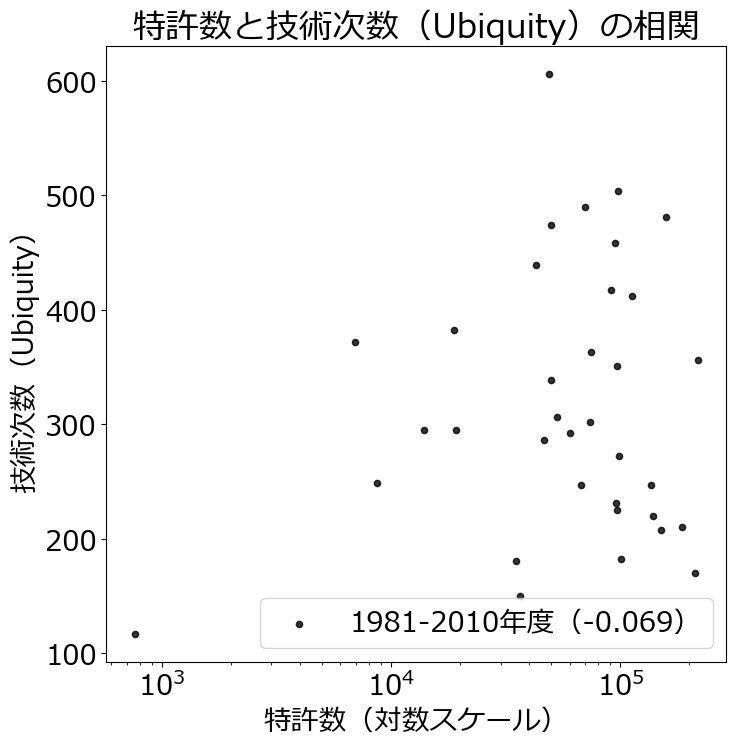

1981-2010 -0.292


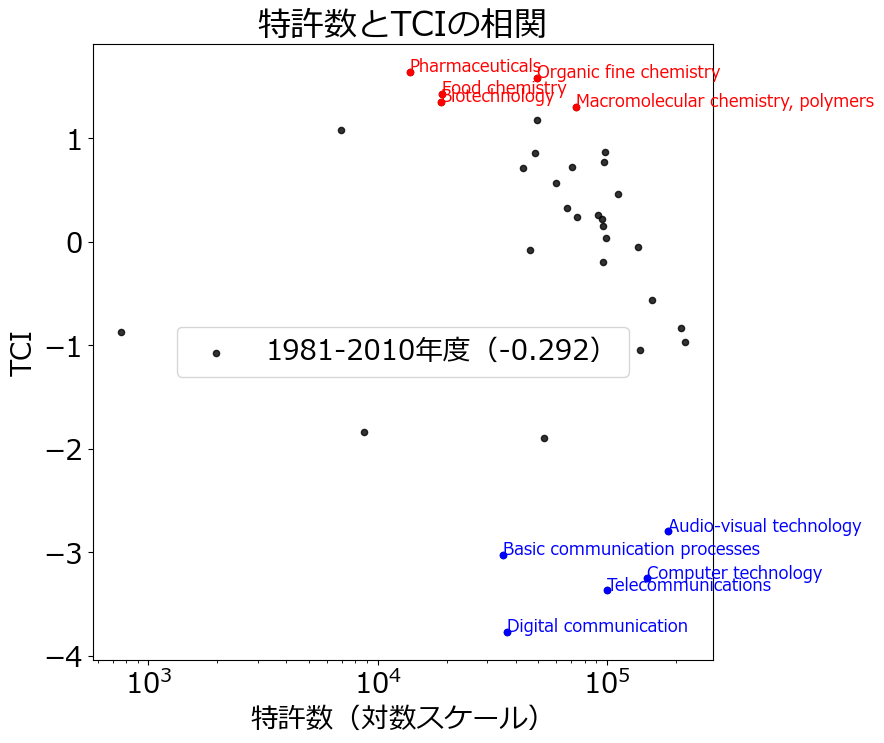

1981-2010 0.594


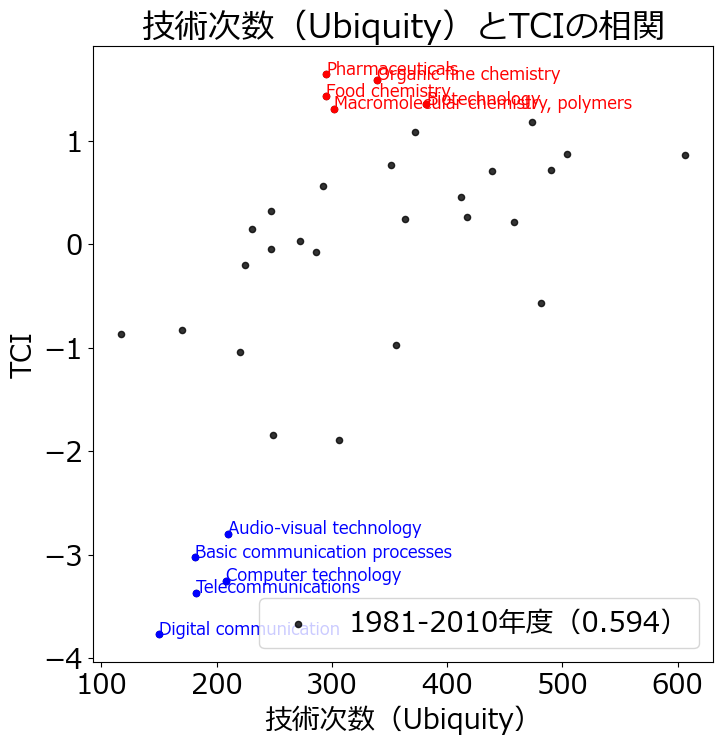

1981-2010 0.064


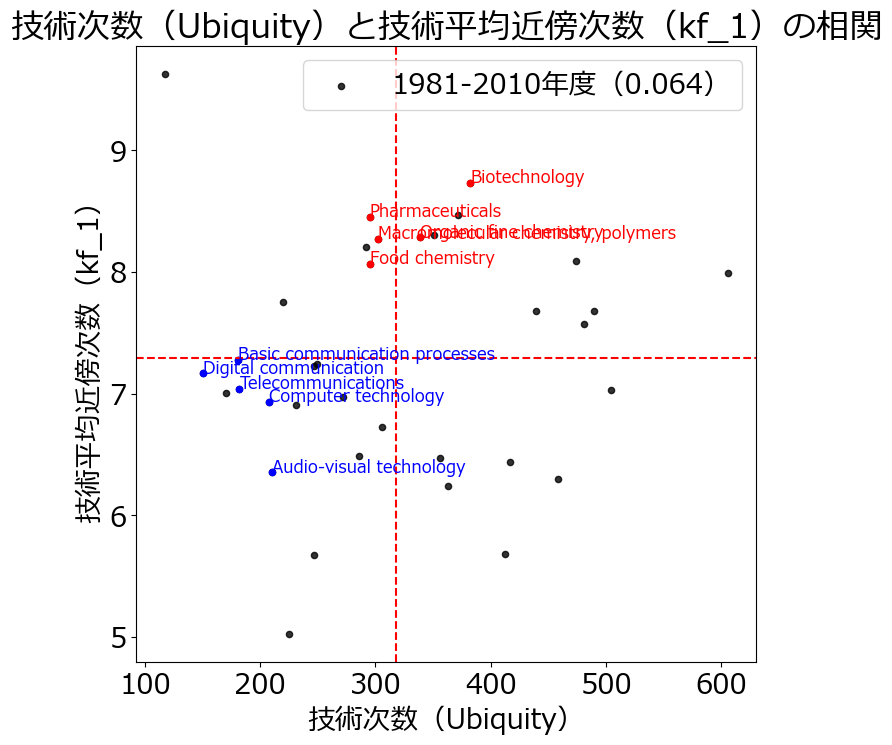

1981-2010 0.151


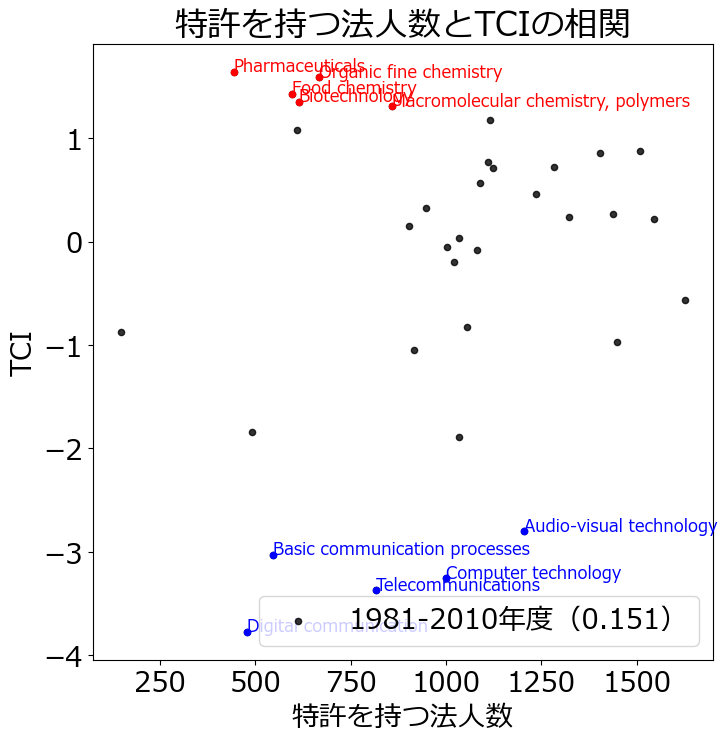

In [14]:
df_dict = {}
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["reg_num", "ubiquity", "特許数と技術次数（Ubiquity）の相関", "特許数（対数スケール）", "技術次数（Ubiquity）", "best", ],
    2: ["reg_num", "tci", "特許数とTCIの相関", "特許数（対数スケール）", "TCI", "best", ],
    3: ["ubiquity", "tci", "技術次数（Ubiquity）とTCIの相関", "技術次数（Ubiquity）", "TCI", "best", ],
    4: ["ubiquity", "ki_1", "技術次数（Ubiquity）と技術平均近傍次数（kf_1）の相関", "技術次数（Ubiquity）", "技術平均近傍次数（kf_1）", "best", ],
    5: [region_corporation, "tci", "特許を持つ法人数とTCIの相関", "特許を持つ法人数", "TCI", "best",  ],
}

for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(df[df[f"{ar}_{year_style}_period"] == period][combi[0]].corr(df[df[f"{ar}_{year_style}_period"] == period][combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(df[df[f"{ar}_{year_style}_period"] == period][combi[0]], df[df[f"{ar}_{year_style}_period"] == period][combi[1]],
               s=20, alpha=0.8, label=f"{period}年度（{corr_num}）", color="black", )
    if i == 4:
        ax.axvline(x=df[df[f"{ar}_{year_style}_period"] == period][combi[0]].mean(), color="red", linestyle="--", )
        ax.axhline(y=df[df[f"{ar}_{year_style}_period"] == period][combi[1]].mean(), color="red", linestyle="--", )
    ax.set_title(combi[2])
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].min()
    x_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[1]].nsmallest(2).iloc[1])
    if i in [2, 3, 4, 5]:
        head_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).head(5))
        tail_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).tail(5))
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row[classification], fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
            
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row[classification], fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    ax.legend(loc=combi[5], fontsize=20)
    plt.show()


In [13]:
# fig, ax = plt.subplots(figsize=(20, 40), squeeze=False, sharey=False)
def plot_to_image(f):
    buf = io.BytesIO()
    f.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img


color_count = 0
img_list = []
for period in range(year_start, year_end + 1, year_range):

    fig, ax = plt.subplots(figsize=(3, 30))
    period = f"{period}-{period+year_range-1}"
    plot_df = (
        df[df[f"{ar}_{year_style}_period"] == period]
        .groupby([classification])[["reg_num"]]
        .sum()
        .sort_values("reg_num", ascending=True)
    )
    ax.barh(
        list(plot_df.index),
        list(plot_df["reg_num"].values),
        color=color_list[color_count],
        label=period,
    )
    ax.set_yticklabels(plot_df.index, fontsize=15)
    ax.set_xticklabels(
        [x for x in range(0, 80000 + 1, 20000)], fontsize=20, rotation=90
    )
    ax.set_xlim(0, 90000)
    # ax.set_xticklabels(fontsize=15, rotation=90)
    xax2 = ax.secondary_xaxis("top")
    # xax2.xaxis.set_major_formatter(ptick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
    xax2.set_xlim(ax.get_xlim())
    ax.legend(fontsize=20, loc="upper center")
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="x", linestyle="--")
    c_i = 0
    for c in plot_df.index:
        reg_num = plot_df[plot_df.index == c]["reg_num"].values[0]
        ax.text(x=40000, y=c_i, s=round(reg_num, 1), fontsize=20, color="black")
        #     ax.set_xticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, rotation=90, fontsize=15)
        c_i += 1
    color_count += 1
    img_list.append(plot_to_image(fig))

    # fig.savefig(f'{output_dir}{ar}_{year_style}_{classification}_{period}.png', bbox_inches='tight')
combined_img = Image.new(
    "RGB", (sum([img.width for img in img_list]), img_list[0].height)
)
w, h = 0, 0
for img_i, img in enumerate(img_list):
    combined_img.paste(img, (w, h))
    w += img.width
combined_img.save(f"{output_dir}tech_reg_num/{fig_name_base}", "PNG")
# combined_img.show()
plt.show()

C:\Users\rin\AppData\Local\Temp\ipykernel_104616\4080642559.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_104616\4080642559.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
C:\Users\rin\AppData\Local\Temp\ipykernel_104616\4080642559.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_104616\4080642559.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\App

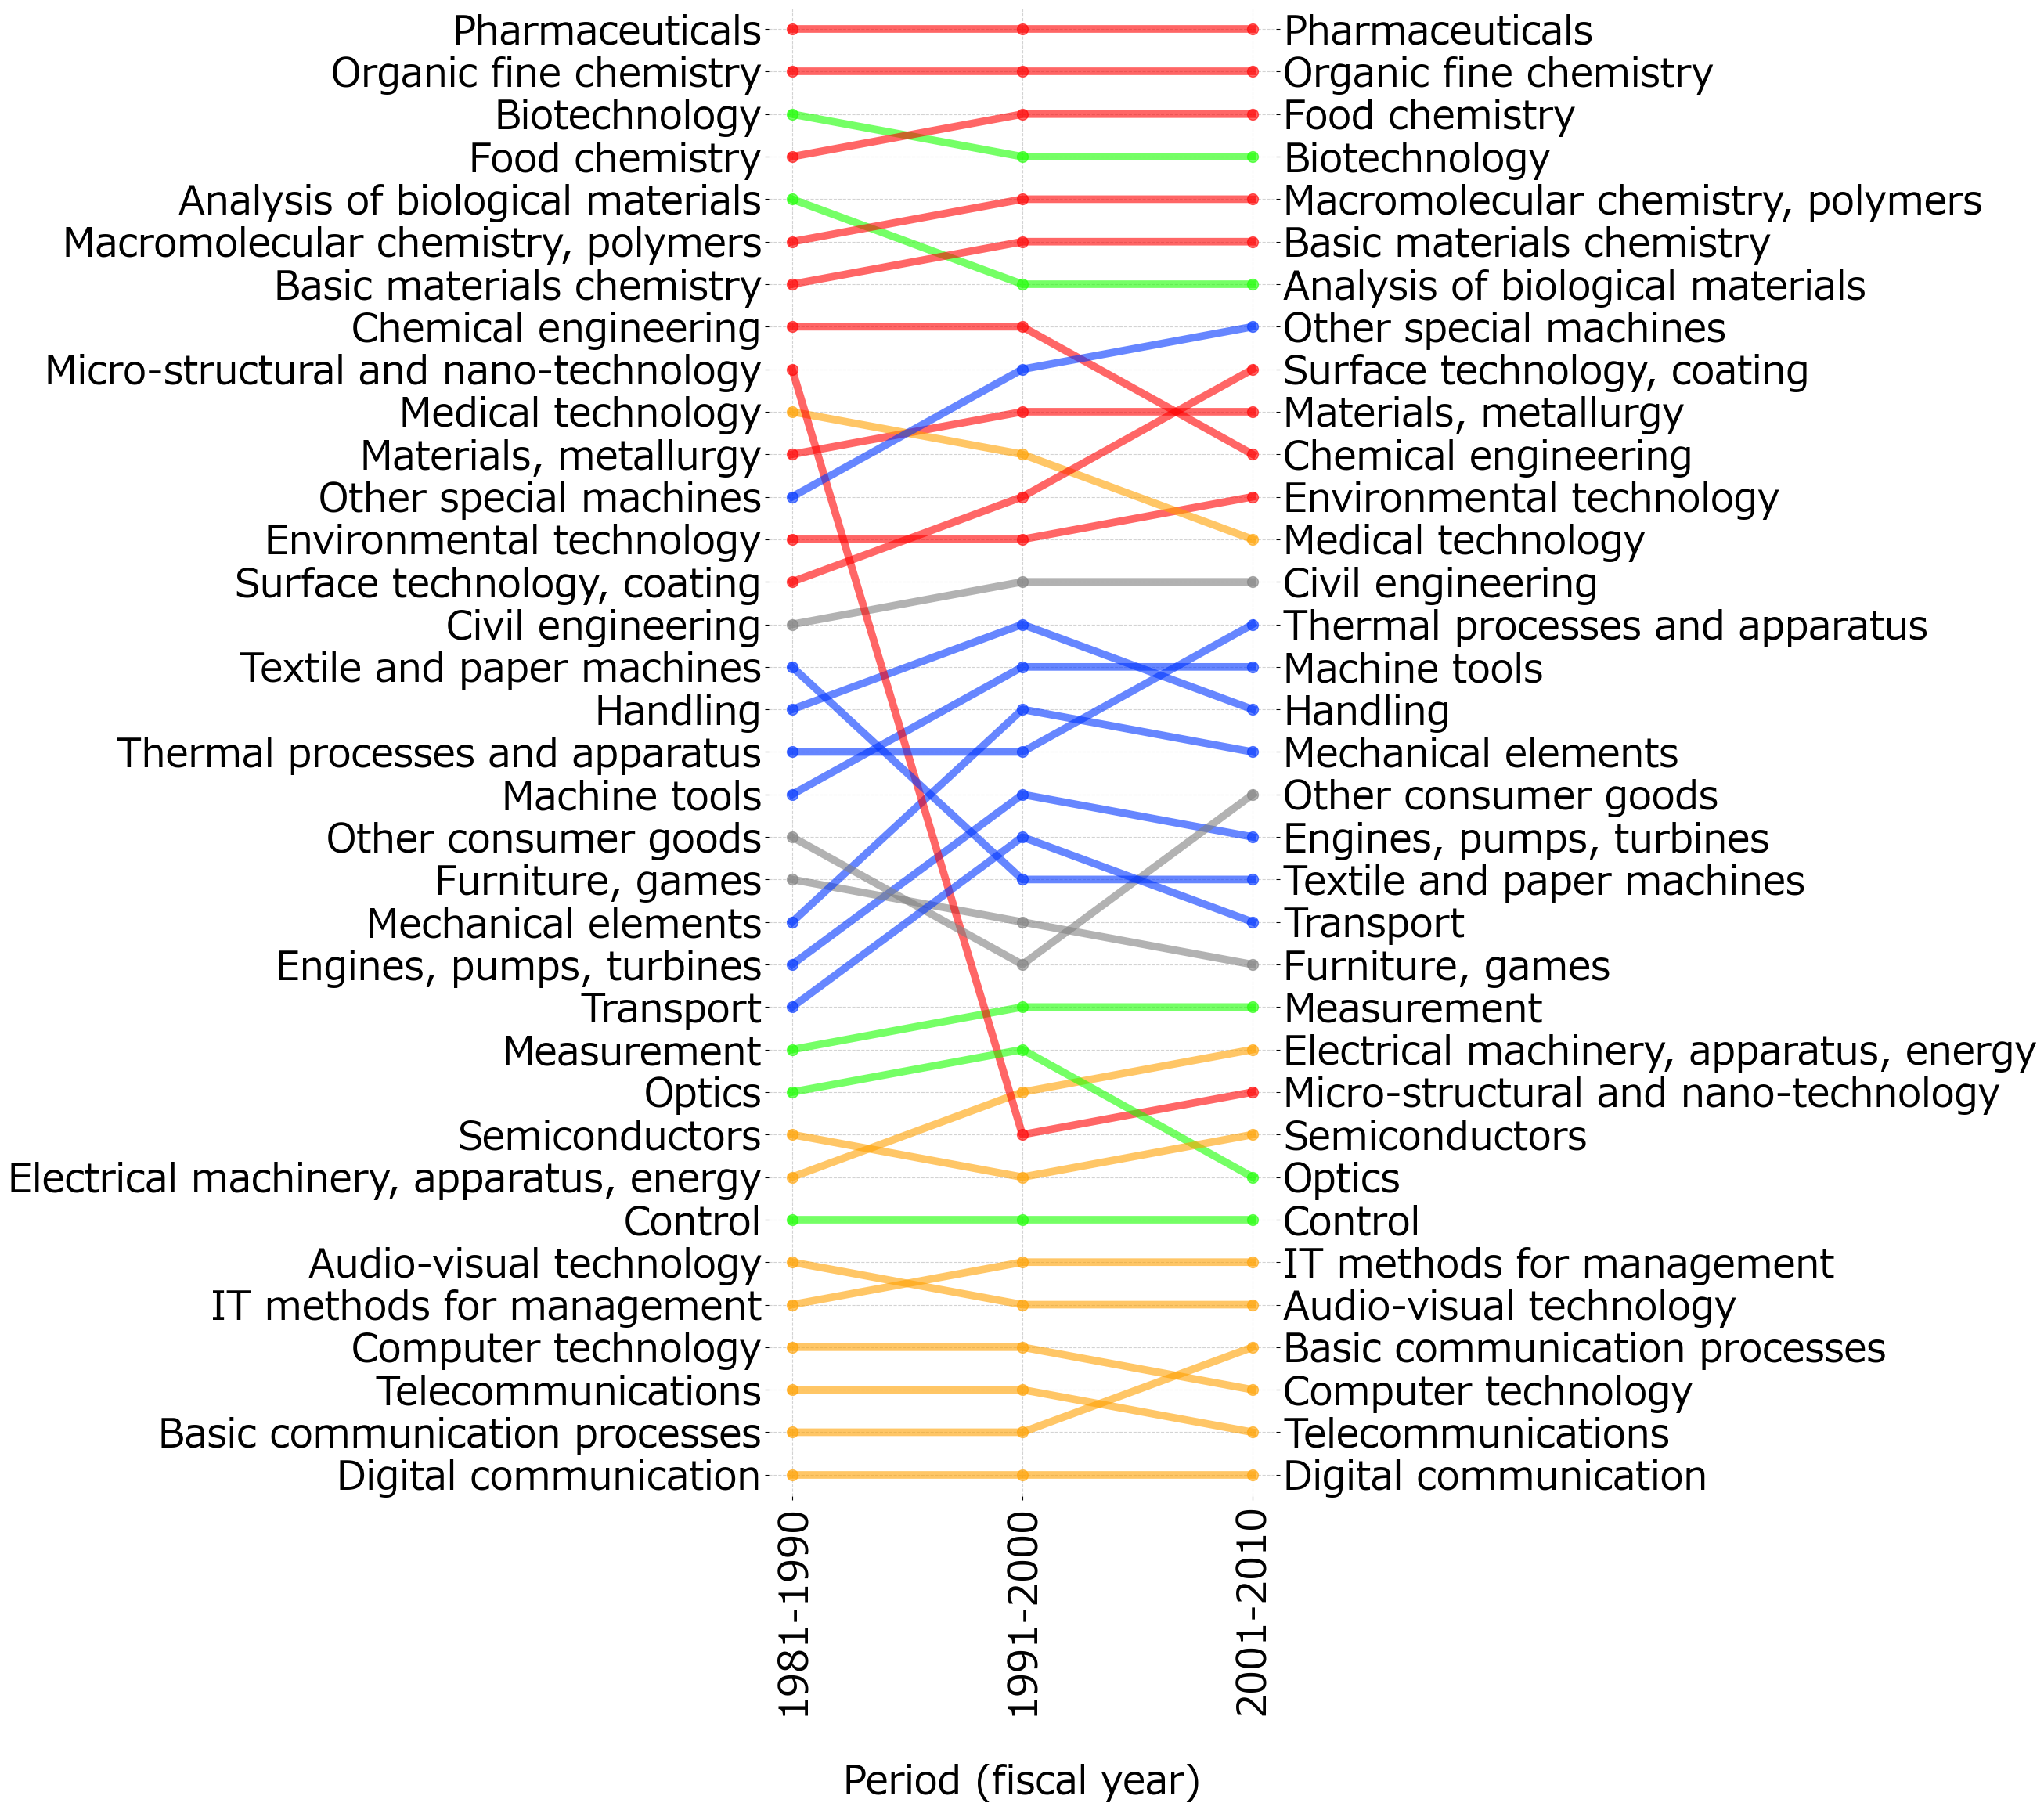

In [19]:
df_dict = {}
combi_dict = {
    #   5: [classification, 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   5: [classification, 'ubiquity', f'', True],
    #   6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False],
    #   7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
    8: [classification, "tci", "", False]
}


for i, combi in combi_dict.items():
    div_df = (
        df[[f"{ar}_{year_style}_period"] + combi[: 1 + 1]]
        .sort_values(
            by=[f"{ar}_{year_style}_period", combi[1]], ascending=[True, False]
        )
        .copy()
    )
    div_df = div_df.drop_duplicates(keep="first")
    div_df_dict = {}
    for year in range(year_start, year_end + 1, year_range):
        period = f"{year}-{year+year_range-1}"
        div_df_dict[period] = div_df[
            div_df[f"{ar}_{year_style}_period"] == period
        ].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i == 4:
        df["kci_rank"] = (
            df.groupby(f"{ar}_{year_style}_period")[["kci"]]
            .rank(ascending=False, method="first")
            .reset_index(drop=False)["kci"]
        )
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4:
        fs = (27, 24)
    else:
        fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(
        div_df_dict,
        rank_num=35,
        member_col=combi[0],
        value_col=combi[1],
        prop_dict={
            "figsize": fs,
            "xlabel": "期間",
            "ylabel": "",
            "title": combi[2],
            "fontsize": 36,
            "year_range": year_range,
            "ascending": combi[3],
            # 'color': color_dict
            "color": "default",
        },
    )
    # plt.tight_layout()
    plt.xlabel("\nPeriod (fiscal year)", fontsize=36)
    plt.savefig(
        f"{output_dir}{combi[1]}_{fig_name_base}",
        bbox_inches="tight",
    )
    plt.show()

In [15]:
sample_df = (
    df[(df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}")]
    .sort_values("tci", ascending=False)
    .copy()

)
sample_df_dict = {
    "0": sample_df.melt(id_vars=[classification], value_vars=["ubiquity"]).sort_values(
        "value", ascending=False
    )
}

fs = (36, 36)

for i in range(2, 20 + 1, 2):

    sample_df_dict[f"{i}"] = sample_df.melt(
        id_vars=[classification], value_vars=[f"ki_{i}"]
    ).sort_values("value", ascending=False)

    # if i >= 12: display(sample_df_dict[f'{i}'].head(10))

sample = vr.rank_doubleaxis(
    sample_df_dict,

    version="kci",

    rank_num=35,

    member_col=classification,
    num_col="value",

    prop_dict={

        "figsize": fs,

        "xlabel": "N",

        "ylabel": "",
        "title": "",

        "fontsize": 40,

        "year_range": 2,
        "ascending": False,
        # 'color': color_dict
        "color": "default",

    },
)

TypeError: rank_doubleaxis() got an unexpected keyword argument 'version'